In [4]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

dbname = 'DataMining'
user = 'postgres'
password = 'datamining'
host = 'localhost'  # localhost or the server address
port = '5433'  # default PostgreSQL port is 5432

# Establish a connection to the database
connection_str = f"postgresql://{user}:{password}@{host}:{port}/{dbname}"
engine = create_engine(connection_str)

In [6]:
query = """
SELECT rs_e_inairtemp_pc1, 
       rs_e_inairtemp_pc2, 
       rs_e_wattemp_pc1, 
       rs_e_wattemp_pc2, 
       rs_t_oiltemp_pc1, 
       rs_t_oiltemp_pc2, 
       rs_e_rpm_pc1, 
       rs_e_rpm_pc2
FROM vehicle_data;
"""

# Execute the query and fetch the data into a DataFrame
df = pd.read_sql_query(query, engine)

# Close the database connection
engine.dispose()

BINNING

In [12]:
# Define your bins
air_bins = [-float('inf'), 25, 45, 60, 65, float('inf')]
water_bins = [-float('inf'), 60, 80, 95, 100, float('inf')]
oil_bins = [-float('inf'), 80, 95, 110, 115, float('inf')]
rpm_bins = [0, 500, 790, 812, 1200, 3000]  # Upper limit set to 3000 as a placeholder

# Define labels for the bins
air_labels = ['<25°C air', '25-45°C air', '45-60°C air', '60-65°C air', '>=65°C air']
water_labels = ['<60°C water', '60-80°C water', '80-95°C water', '95-100°C water', '>=100°C water']
oil_labels = ['<80°C oil', '80-95°C oil', '95-110°C oil', '110-115°C oil', '>=115°C oil']
rpm_labels = ['Very Low RPM', 'Low RPM', 'Medium RPM', 'High RPM', 'Very High RPM']

# Bin the temperature and RPM columns
temp_columns = ['rs_e_inairtemp_pc1', 'rs_e_inairtemp_pc2', 'rs_e_wattemp_pc1', 'rs_e_wattemp_pc2', 'rs_t_oiltemp_pc1', 'rs_t_oiltemp_pc2']
rpm_columns = ['rs_e_rpm_pc1', 'rs_e_rpm_pc2']

for col in temp_columns:
    if 'inair' in col:
        df[col + '_bin'] = pd.cut(df[col], bins=air_bins, labels=air_labels, right=False)
    elif 'wattemp' in col:
        df[col + '_bin'] = pd.cut(df[col], bins=water_bins, labels=water_labels, right=False)
    elif 'oiltemp' in col:
        df[col + '_bin'] = pd.cut(df[col], bins=oil_bins, labels=oil_labels, right=False)

for col in rpm_columns:
    df[col + '_bin'] = pd.cut(df[col], bins=rpm_bins, labels=rpm_labels, right=False)

DATA EXPLORATION BINS

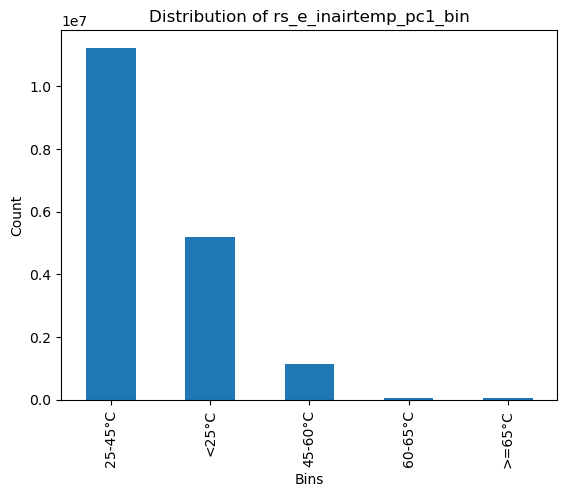

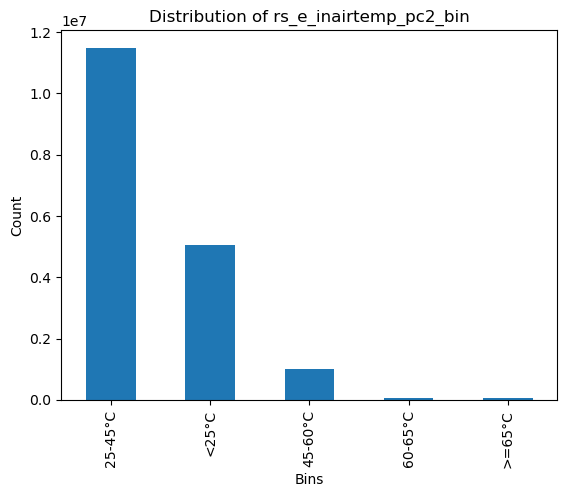

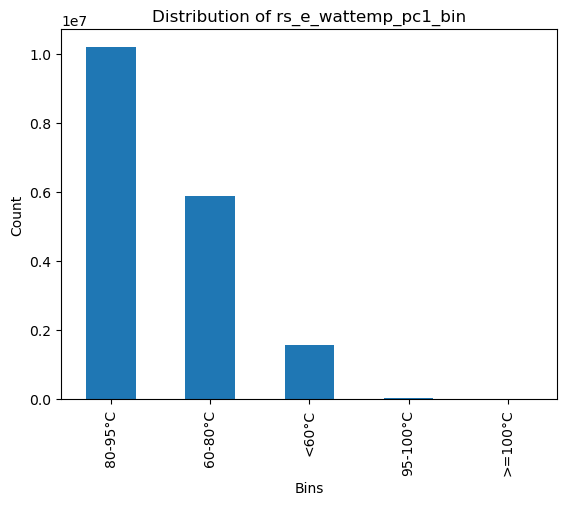

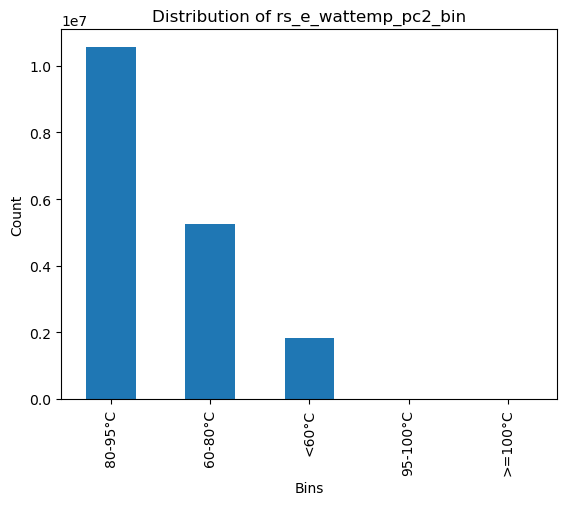

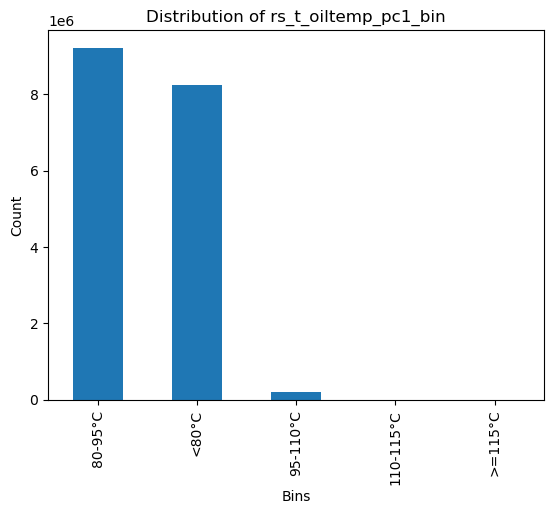

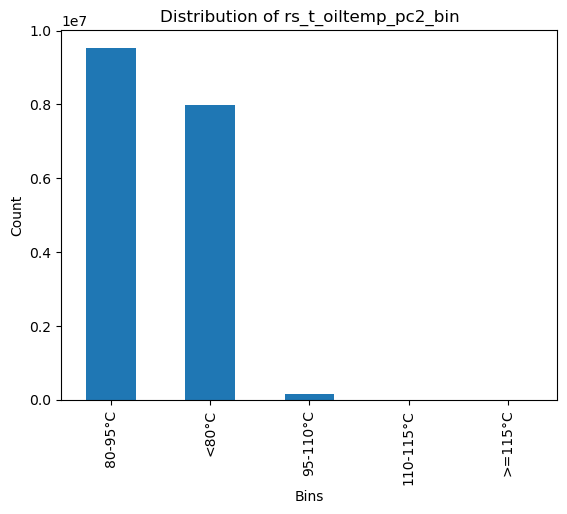

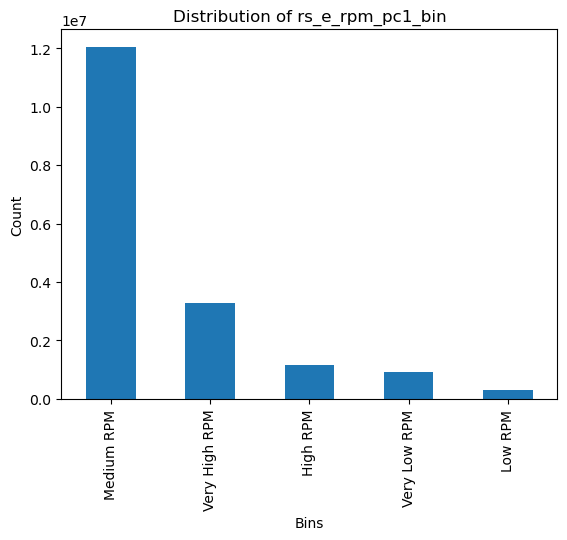

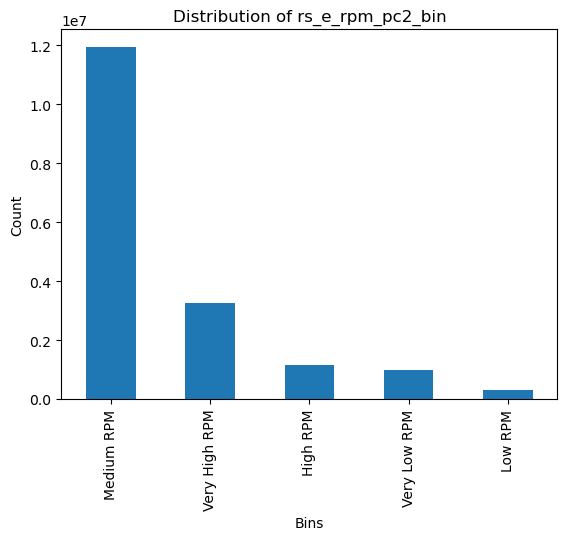

In [10]:
# Example: Plotting the distribution of one of the binned columns
binned_columns = [col for col in df.columns if '_bin' in col]

for col in binned_columns:
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.ylabel('Count')
    plt.xlabel('Bins')
    plt.show()

FREQUENT PATTERN MINING: APRIORI

In [13]:
# Convert the DataFrame into a list of transactions, ensuring all items are strings
transactions = df[binned_columns].astype(str).values.tolist()

# Now apply the TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)

# Apply the Apriori algorithm to find frequent item sets
print('start apriori alg')
frequent_itemsets = apriori(df_transactions, min_support=0.1, use_colnames=True)  # Adjust min_support as needed

# Display frequent item sets
print(frequent_itemsets.sort_values(by='support', ascending=False))

start apriori alg
     support                                           itemsets
0   0.751840                                      (25-45°C air)
7   0.729412                                       (Medium RPM)
3   0.713248                                    (80-95°C water)
2   0.628524                                      (80-95°C oil)
11  0.626166                       (80-95°C water, 25-45°C air)
..       ...                                                ...
85  0.105016  (<80°C oil, 80-95°C water, Medium RPM, 80-95°C...
68  0.104950               (Medium RPM, <80°C oil, <60°C water)
58  0.102970            (80-95°C water, <25°C air, 80-95°C oil)
66  0.101945                (<80°C oil, <25°C air, <60°C water)
83  0.100690  (60-80°C water, 80-95°C water, Medium RPM, 80-...

[86 rows x 2 columns]


In [14]:
frequent_itemsets_sorted = frequent_itemsets.sort_values(by='support', ascending=False)
frequent_itemsets_sorted.to_csv('apriori_frequent_itemsets.csv', index=False)

FREQUENT PATTERN MINING: FP GROWTH

In [15]:
from mlxtend.frequent_patterns import fpgrowth

# Apply the FP-Growth algorithm to find frequent item sets
frequent_itemsets_fp = fpgrowth(df_transactions, min_support=0.1, use_colnames=True)

# Display frequent item sets found by FP-Growth
print(frequent_itemsets_fp.sort_values(by='support', ascending=False))

     support                                           itemsets
4   0.751840                                      (25-45°C air)
0   0.729412                                       (Medium RPM)
5   0.713248                                    (80-95°C water)
6   0.628524                                      (80-95°C oil)
45  0.626166                       (80-95°C water, 25-45°C air)
..       ...                                                ...
23  0.105016  (<80°C oil, 80-95°C water, Medium RPM, 80-95°C...
43  0.104950               (Medium RPM, <80°C oil, <60°C water)
37  0.102970            (80-95°C water, <25°C air, 80-95°C oil)
44  0.101945                (<80°C oil, <25°C air, <60°C water)
75  0.100690  (60-80°C water, 80-95°C water, Medium RPM, 80-...

[86 rows x 2 columns]


In [16]:
frequent_itemsets_sorted_fp = frequent_itemsets_fp.sort_values(by='support', ascending=False)
frequent_itemsets_sorted_fp.to_csv('fp_frequent_itemsets.csv', index=False)